# 1. Setup and Get Data

### Install Dependencies and Setup

### Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2
from PIL import Image

In [5]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [9]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [3]:
cap.release()

cv2.destroyAllWindows()

### Annotate Images with LabelMe

In [11]:
!labelme

2024-06-04 16:32:53,321 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\kdkas\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### Load Image into TF Data Pipeline

In [13]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [14]:
images.as_numpy_iterator().next()

b'data\\images\\bb73fdf9-2260-11ef-8b08-58fb8426716c.jpg'

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
images = images.map(load_image)

In [17]:
images.as_numpy_iterator().next()

array([[[154, 158, 167],
        [152, 161, 168],
        [150, 163, 172],
        ...,
        [ 24,  76,  54],
        [ 58, 107,  85],
        [ 34,  83,  61]],

       [[149, 153, 162],
        [147, 156, 165],
        [145, 159, 168],
        ...,
        [ 38,  87,  66],
        [ 64, 111,  91],
        [ 44,  92,  70]],

       [[148, 155, 165],
        [147, 157, 166],
        [145, 159, 168],
        ...,
        [ 51,  98,  78],
        [ 63, 108,  88],
        [ 50,  95,  75]],

       ...,

       [[ 45,  40,  36],
        [ 44,  39,  35],
        [ 45,  37,  34],
        ...,
        [ 32,  74,  60],
        [ 32,  76,  61],
        [ 31,  78,  62]],

       [[ 41,  37,  34],
        [ 43,  39,  36],
        [ 45,  40,  37],
        ...,
        [ 23,  71,  59],
        [ 20,  70,  58],
        [ 22,  74,  61]],

       [[ 41,  37,  34],
        [ 45,  41,  38],
        [ 48,  43,  40],
        ...,
        [ 23,  75,  63],
        [ 19,  71,  59],
        [ 19,  73,  60]]

In [18]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### View Raw Images with Matplotlib

In [19]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

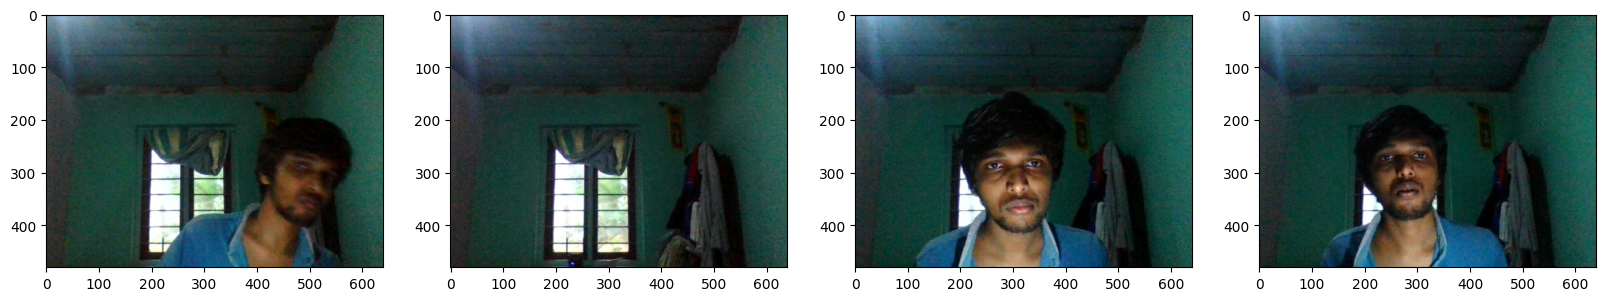

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### Move the Matching Labels

In [22]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### Setup Albumentations Transform Pipeline

In [23]:
import albumentations as alb

In [24]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Load a Test Image and Annotation with OpenCV and JSON

In [25]:
img = cv2.imread(os.path.join('data','train', 'images','c1f0f1ac-2260-11ef-a316-58fb8426716c.jpg'))

In [26]:
with open(os.path.join('data', 'train', 'labels', 'c1f0f1ac-2260-11ef-a316-58fb8426716c.json'), 'r') as f:
    label = json.load(f)

In [27]:
label['shapes'][0]['points']

[[184.38848920863313, 179.56834532374103],
 [368.5611510791367, 428.4892086330935]]

### Extract Coordinates and Rescale to Match Image Resolution

In [28]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords

[184.38848920863313, 179.56834532374103, 368.5611510791367, 428.4892086330935]

In [30]:
coords = list(np.divide(coords, [640,480,640,480]))

In [31]:
coords

[0.2881070143884893,
 0.3741007194244605,
 0.5758767985611511,
 0.8926858513189447]

### Apply Augmentations and View Results

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [33]:
augmented['bboxes'][0][2:]

(0.6035811350919263, 0.6187370103916866)

In [34]:
augmented['bboxes']

[(0.19430855315747397,
  0.06557953637090341,
  0.6035811350919263,
  0.6187370103916866)]

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### Run Augmentation Pipeline

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.24763938848920866, 0.9166666666666665, 0.002585431654676329, 0.5164868105515588, 'face'].
x_max is less than or equal to x_min for bbox [0.32632643884892093, 0.9196642685851318, 0.06216276978417272, 0.46402877697841727, 'face'].
x_max is less than or equal to x_min for bbox [0.138601618705036, 0.9946043165467625, 0.0, 0.5138508758210819, 'face'].
x_max is less than or equal to x_min for bbox [0.21054406474820153, 0.9916067146282972, -4.4408920985006264e-17, 0.500697134600012, 'face'].
x_max is less than or equal to x_min for bbox [0.17457284172661874, 0.9781175059952038, 0.0, 0.5668538788601019, 'face'].
x_max is less than or equal to x_min for bbox [0.32183003597122306, 0.3471223021582734, 0.034060251798561224, 0.006894484412470058, 'face'].


### Load Augmented Images to Tensorflow Dataset

In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.04546569, 0.10379902, 0.06605392],
        [0.08284314, 0.11023284, 0.0942402 ],
        [0.04932598, 0.0846201 , 0.07285539],
        ...,
        [0.32971814, 0.48363972, 0.5321691 ],
        [0.36158088, 0.4958946 , 0.5360907 ],
        [0.35827205, 0.49264705, 0.54313725]],

       [[0.08088236, 0.14381127, 0.10177696],
        [0.09993873, 0.13737746, 0.10790441],
        [0.10692402, 0.14221814, 0.12261029],
        ...,
        [0.35104167, 0.47935048, 0.5382353 ],
        [0.3435049 , 0.4675245 , 0.5129902 ],
        [0.37469363, 0.48253676, 0.5348652 ]],

       [[0.10361519, 0.1643995 , 0.12665442],
        [0.09754902, 0.14019608, 0.10882353],
        [0.10655637, 0.14185049, 0.12224264],
        ...,
        [0.32757354, 0.44129902, 0.49620098],
        [0.3435049 , 0.45330882, 0.501348  ],
        [0.34209558, 0.46372548, 0.5120711 ]],

       ...,

       [[0.06942402, 0.15974265, 0.25012255],
        [0.05808824, 0.16495098, 0.28400734],
        [0.05625   , 0

# 6. Prepare Labels

### Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels = train_labels.map(lambda x, y: (tf.reshape(x, [1]), tf.reshape(y, [4])))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = test_labels.map(lambda x, y: (tf.reshape(x, [1]), tf.reshape(y, [4])))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = val_labels.map(lambda x, y: (tf.reshape(x, [1]), tf.reshape(y, [4])))

In [12]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.193 , 0.3875, 0.4983, 0.8013], dtype=float16))

# 7. Combine Label and Image Samples

### Check Partition Lengths

In [13]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3540, 3540, 780, 780, 720, 720)

### Create Final Datasets (Images/Labels)

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [17]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.7046, 0.3604, 1.    , 0.8413],
        [0.3125, 0.3706, 0.6816, 0.8584],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.5728, 0.1812, 1.    ],
        [0.3284, 0.4473, 0.634 , 0.8613],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### View Images and Annotations

In [18]:
data_samples = train.as_numpy_iterator()

In [19]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    s = cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)

    ax[idx].imshow(s)

# 8. Build Deep Learning using the Functional API

### Import Layers and Base Network

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [22]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

### Build instance of Network

In [24]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### Test out Neural Network

In [25]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [27]:
X, y = train.as_numpy_iterator().next()

In [28]:
X.shape

(8, 120, 120, 3)

In [29]:
y

(array([[0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.1538, 0.297 , 0.5664, 0.8677],
        [0.294 , 0.1895, 0.614 , 0.6   ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2208, 0.4617, 0.5244, 0.863 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.0994, 0.2512, 0.6206]], dtype=float16))

In [30]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [31]:
classes, coords

(array([[0.388321  ],
        [0.47939873],
        [0.4322642 ],
        [0.39994642],
        [0.37184665],
        [0.43598038],
        [0.39384866],
        [0.39091972]], dtype=float32),
 array([[0.3184719 , 0.31270298, 0.47724402, 0.32815862],
        [0.38617942, 0.25354   , 0.44383532, 0.40342802],
        [0.2861261 , 0.20076264, 0.34917042, 0.45791385],
        [0.3304872 , 0.30130106, 0.50049317, 0.3348565 ],
        [0.32418153, 0.30161238, 0.49841675, 0.3528336 ],
        [0.32945484, 0.271369  , 0.42451498, 0.41582805],
        [0.34716442, 0.33245572, 0.43343428, 0.39714295],
        [0.23250033, 0.20150839, 0.32258254, 0.402916  ]], dtype=float32))

In [32]:
coords.shape

(8, 4)

# 9. Define Losses and Optimizers

### Define Optimizer and LR

In [33]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\kdkas\Desktop\projects\cnn simple emotion\venv\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Create Localization Loss and Classification Loss

In [38]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [36]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### Test out Loss Metrics

In [37]:
y[0].shape

(8, 1)

In [39]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.724736>

In [40]:
classes

array([[0.388321  ],
       [0.47939873],
       [0.4322642 ],
       [0.39994642],
       [0.37184665],
       [0.43598038],
       [0.39384866],
       [0.39091972]], dtype=float32)

In [41]:
x = classloss(y[0], classes)

In [42]:
x.shape

TensorShape([])

In [43]:
tf.reshape(x,[])

<tf.Tensor: shape=(), dtype=float32, numpy=0.66390413>

In [44]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.724736>

In [214]:


# Given number
number = 3.14

# Convert the number to a TensorFlow tensor
tensor = tf.constant(number)

# Convert the tensor to an integer type (e.g., tf.int32)
tensor_int = tf.cast(tensor, tf.int32)

print(tensor_int)


tf.Tensor(3, shape=(), dtype=int32)


# 10. Train Neural Network

### Create Custom Model Class

In [45]:
@tf.keras.utils.register_keras_serializable()
class FaceTracker(Model):
    def __init__(self, facetracker,  **kwargs):
        super().__init__(**kwargs)
        self.facetracker = facetracker

    def get_config(self):
        base_config = super().get_config()
        config = {
            "facetracker": tf.keras.utils.serialize_keras_object(self.facetracker),
        }
        return {**base_config, **config}
    
    @classmethod
    def from_config(cls, config):
        sublayer_config = config.pop("facetracker")
        sublayer = tf.keras.utils.deserialize_keras_object(sublayer_config)
        return cls(sublayer, **config)

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.facetracker(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.facetracker.trainable_variables)

        opt.apply_gradients(zip(grad, self.facetracker.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.facetracker(X, training=False)

        batch_classloss = self.closs(tf.cast(y[0], tf.float32), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X):
        return self.facetracker(X)

In [46]:
model = FaceTracker(facetracker)

In [47]:
model.compile(opt, classloss, regressloss)

### Train

In [48]:
logdir='logs'

In [49]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [50]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
443/443 ━━━━━━━━━━━━━━━━━━━━ 1319s 3s/step - class_loss: 0.0577 - regress_loss: 0.1776 - total_loss: 0.2065 - val_class_loss: 0.0020 - val_regress_loss: 0.0494 - val_total_loss: 0.0504
Epoch 2/3
443/443 ━━━━━━━━━━━━━━━━━━━━ 1240s 3s/step - class_loss: 0.0210 - regress_loss: 0.0601 - total_loss: 0.0706 - val_class_loss: 0.0102 - val_regress_loss: 0.0838 - val_total_loss: 0.0889
Epoch 3/3
443/443 ━━━━━━━━━━━━━━━━━━━━ 1277s 3s/step - class_loss: 0.0194 - regress_loss: 0.0647 - total_loss: 0.0744 - val_class_loss: 0.0028 - val_regress_loss: 0.0498 - val_total_loss: 0.0512


### Plot Performance

In [51]:
hist.history

{'class_loss': [7.905992970336229e-05,
  0.0028057757299393415,
  0.00012510086526162922],
 'regress_loss': [0.02438228949904442,
  0.020297590643167496,
  0.008693406358361244],
 'total_loss': [0.024421818554401398,
  0.021700479090213776,
  0.008755956776440144],
 'val_class_loss': [0.002015909645706415,
  0.01020786352455616,
  0.0028418367728590965],
 'val_regress_loss': [0.04940209537744522,
  0.08382929116487503,
  0.049814291298389435],
 'val_total_loss': [0.05041005089879036,
  0.08893322199583054,
  0.05123521015048027]}

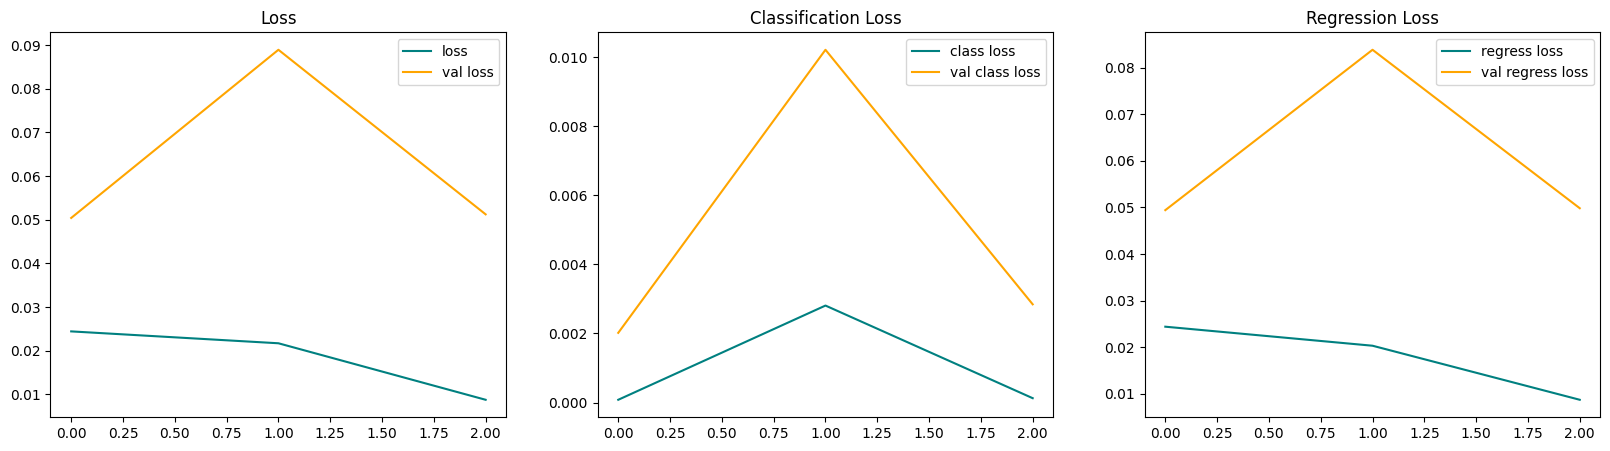

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### Make Predictions on Test Set

In [60]:
test_data = test.as_numpy_iterator()

In [66]:
test_sample = test_data.next()

In [67]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Save the Model

In [69]:
from tensorflow.keras.models import load_model

In [70]:
facetracker.save('facetracker.h5')

In [72]:
facetracker2 = load_model('facetracker.h5')

### Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker2.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [76]:
cap.release()
cv2.destroyAllWindows()